# GeoCluster 1st hierarchy

Load required libraries and initiate basic objects.

In [1]:
# External libraries.
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
# Internal libraries.
from src.utils.data import loadData
from src import visualization as vis

Loading data...
Data loaded.
[100.         290.           1.           0.35545887]


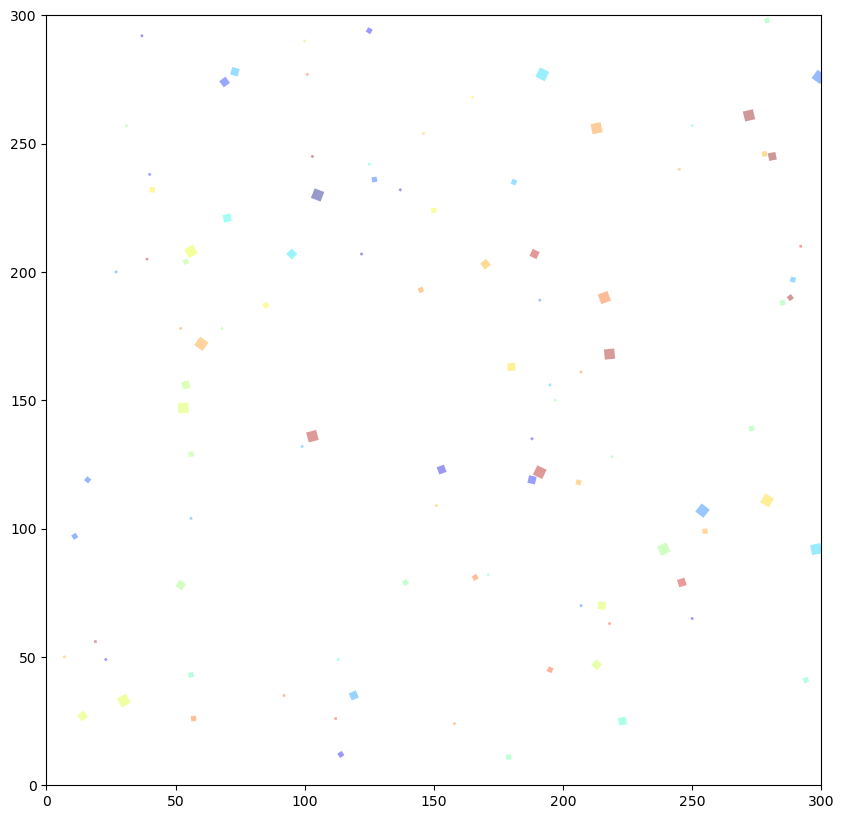

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load data.
squares, _ = loadData(100)
print(squares[0])
vis.plot_data(squares, limits=[0, 300, 0, 300])

## Training Teacher

In [3]:
from src.models import LVGEBM
from src.train import trainTeacher

model = LVGEBM(4, 2, 400).to(device)
learning_rate = 1e-2
results = trainTeacher(model,
                       optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate),
                       epochs=200,
                       times=10,
                       device=device,
                       train_data=torch.from_numpy(squares).float().to(device),
                       alpha=5,
                       beta=10)

# Save results to .npy format.
np.save("models/squares/100/teacher_config.npy", results)
print("Saved teacher config to models/squares/100/teacher_config.npy")

Training Teacher Model
Epoch: 20/200..  Training loss: 12355.38281..  Reg Proj: 0.00000..  Reg Latent: 0.46487..  Memory: 12350.73438..  Cost: 12355.38281.. 
Epoch: 40/200..  Training loss: 7677.14844..  Reg Proj: 0.00000..  Reg Latent: 0.12208..  Memory: 7675.92773..  Cost: 7677.14844.. 
Epoch: 60/200..  Training loss: 7405.02051..  Reg Proj: 0.00000..  Reg Latent: 0.22799..  Memory: 7402.74072..  Cost: 7405.02051.. 
Epoch: 80/200..  Training loss: 8880.76562..  Reg Proj: 0.00000..  Reg Latent: 0.57478..  Memory: 8875.01758..  Cost: 8880.76562.. 
Epoch: 100/200..  Training loss: 7585.94092..  Reg Proj: 0.00000..  Reg Latent: 0.29994..  Memory: 7582.94141..  Cost: 7585.94092.. 
Epoch: 120/200..  Training loss: 8573.29688..  Reg Proj: 0.00000..  Reg Latent: 1.34810..  Memory: 8559.81543..  Cost: 8573.29688.. 
Epoch: 140/200..  Training loss: 9177.03906..  Reg Proj: 0.00000..  Reg Latent: 0.14629..  Memory: 9175.57617..  Cost: 9177.03906.. 
Epoch: 160/200..  Training loss: 8588.53711..  

In [4]:
# Load model from configuration, i.e. a dictionary in .npy format (No need to train each time).
results = np.load('./models/squares/100/teacher_config.npy', allow_pickle=True).item()
print("Loaded teacher config from models/squares/100/teacher_config.npy")

Loaded teacher config from models/squares/100/teacher_config.npy


Load and print some important variables.

In [5]:
model = results["best_model"]
best_epoch = results["best_epoch"]
best_outputs = results["best_outputs"]
print("best epoch: ", best_epoch)
print("best outputs: ", best_outputs)
# print("costs: ", results["cost_array"])

best epoch:  26
best outputs:  tensor([[251.9041,  77.4481],
        [167.2062, 106.3992],
        [218.4973, 241.9978],
        [ 60.8471, 212.9825]], requires_grad=True)


Plot results

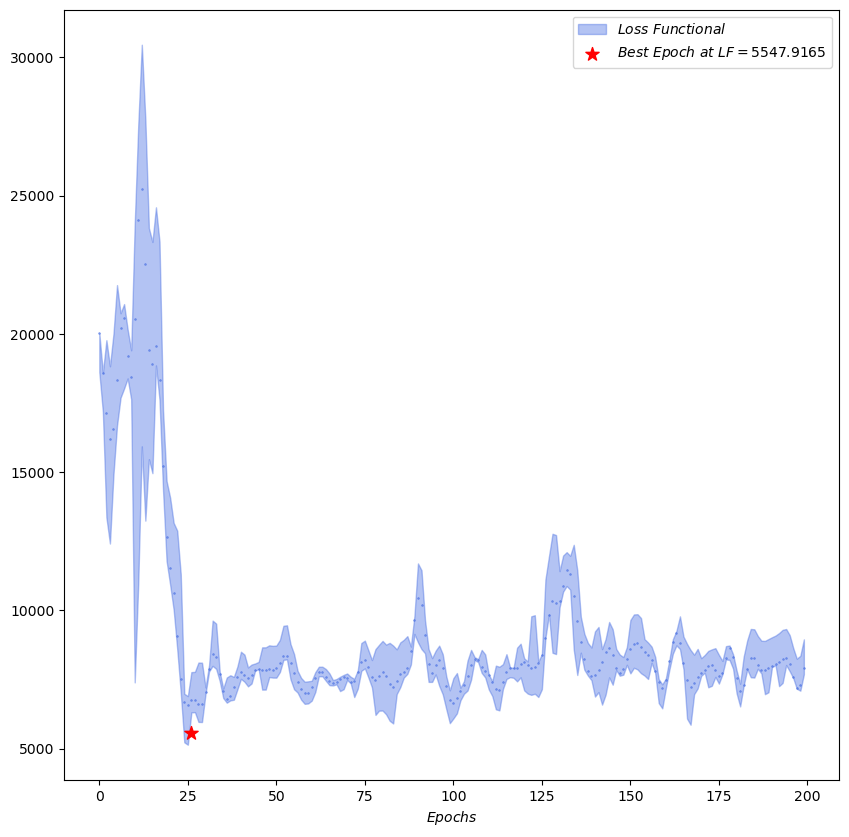

In [6]:
# Plot the Amplitude demodulation of the signal (costs array).
from src.utils.plot_tools import plot_AM_dem, AM_dem

signal = results["cost_array"]
upper_signal, lower_signal, filtered_signal = AM_dem(signal, fc=0.4*len(signal), fs=2*len(signal))
plot_AM_dem(upper_signal, lower_signal, filtered_signal, signal, best_epoch)

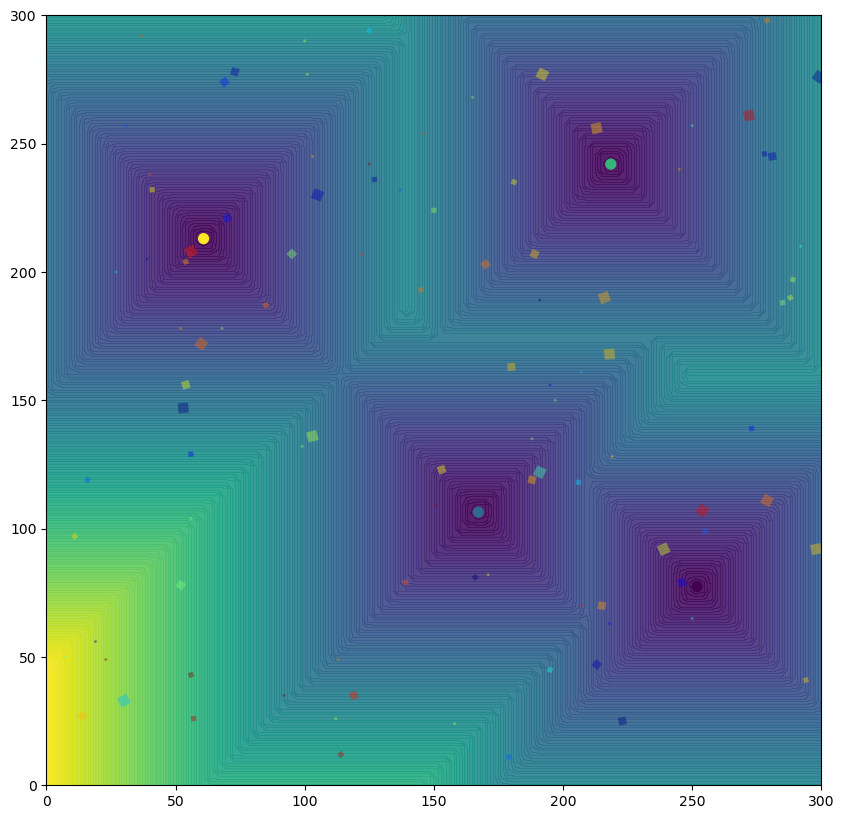

In [7]:
# Plot the best model with the best outputs.
from src.utils import plot_tools as pt
manifold = pt.createManifold(model, best_outputs.cpu())
pt.plotManifold(squares, manifold, best_outputs.cpu(), [0, 300], [0, 300])

## Uncertainty Area

Predicting...


/home/getekid/Sites/athenarc/GeoCluster/src/utils/functions.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  E = Linf_array(torch.tensor(n_points), torch.tensor(outputs))


Processing...
flag is 5778
m is 4223
i is 10000
Points sampled:  4223


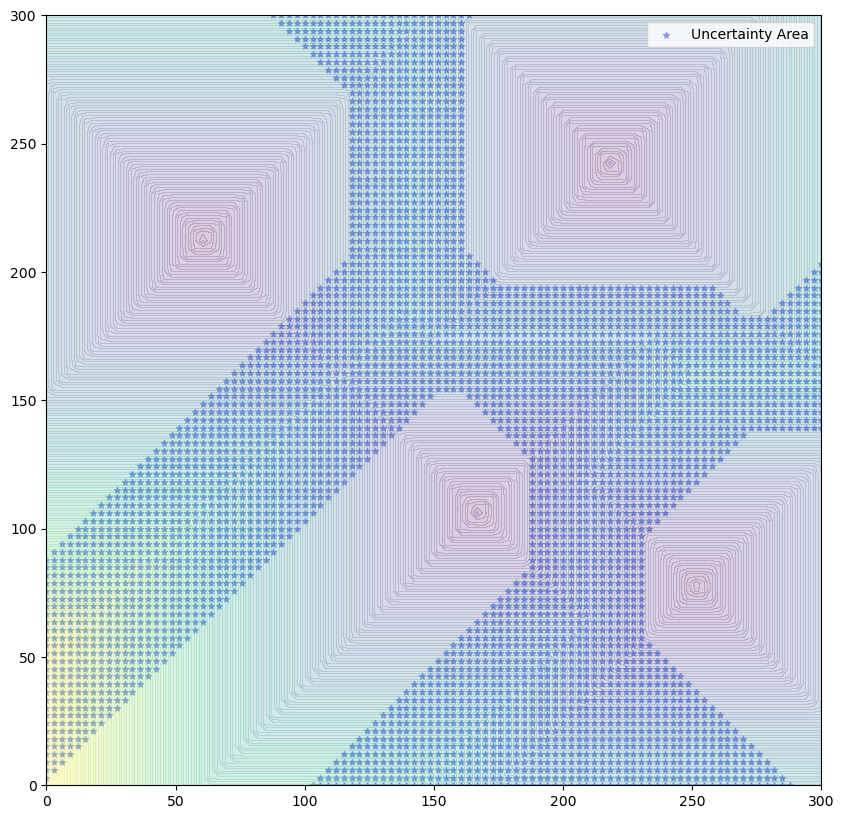

In [8]:
from src.utils.functions import getUncertaintyArea

sensitivity = 0.15
print('Predicting...')
m_points = getUncertaintyArea(best_outputs.cpu().detach().numpy(),
                              N=100,
                              M=10000-1,
                              epsilon=sensitivity,
                              x_area=[0,300],
                              y_area=[0,300],
                              model=model)
print('Points sampled: ', len(m_points))

# Plot the m points that are in the uncertainty area.
m_points = np.array(m_points)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(m_points[:, 0], m_points[:, 1], s=20, c='royalblue', alpha=0.5, marker='*', label='Uncertainty Area')
ax.contourf(manifold[:, :, 0], manifold[:, :, 1], manifold[:, :, -2], levels=200, cmap='viridis', alpha=0.2)
plt.legend()

## Labeling

In [9]:
from src.utils.functions import getE

qp = np.random.permutation(m_points)
qp = torch.tensor(qp)
# TODO: Pass squares to getE as an argument.
F, z, F_sq, z_sq = getE(model, best_outputs.cpu(), qp)

# Initialize the pseudo clusters.
# Append squares that their z_sq is i for each centroid.
pseudo_clusters = [squares[z_sq == i] for i in range(model.n_centroids)]

/home/getekid/Sites/athenarc/GeoCluster/src/utils/functions.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp)
/home/getekid/Sites/athenarc/GeoCluster/src/utils/functions.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs)


Loading data...
Data loaded.


### Create Labels

In [10]:
from src.utils.functions import NearestNeighbour

outputs_shape = (qp.shape[0], model.n_centroids)
F_ps = torch.zeros(outputs_shape)
z_ps = torch.zeros(outputs_shape)
for i in range(outputs_shape[0]):
    if i % 1000 == 0:
        print(f"Labeled {i}/{outputs_shape[0]} points.")
    for j in range(outputs_shape[1]):
        qpoint = qp[i].cpu().detach().numpy()
        F_ps[i,j], z_ps[i,j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j]))
print(f"Labeled all {outputs_shape[0]}/{outputs_shape[0]} points.")
        

Labeled 0/4223 points.
Labeled 1000/4223 points.
Labeled 2000/4223 points.
Labeled 3000/4223 points.
Labeled 4000/4223 points.
Labeled all 4223/4223 points.


### Plot labels

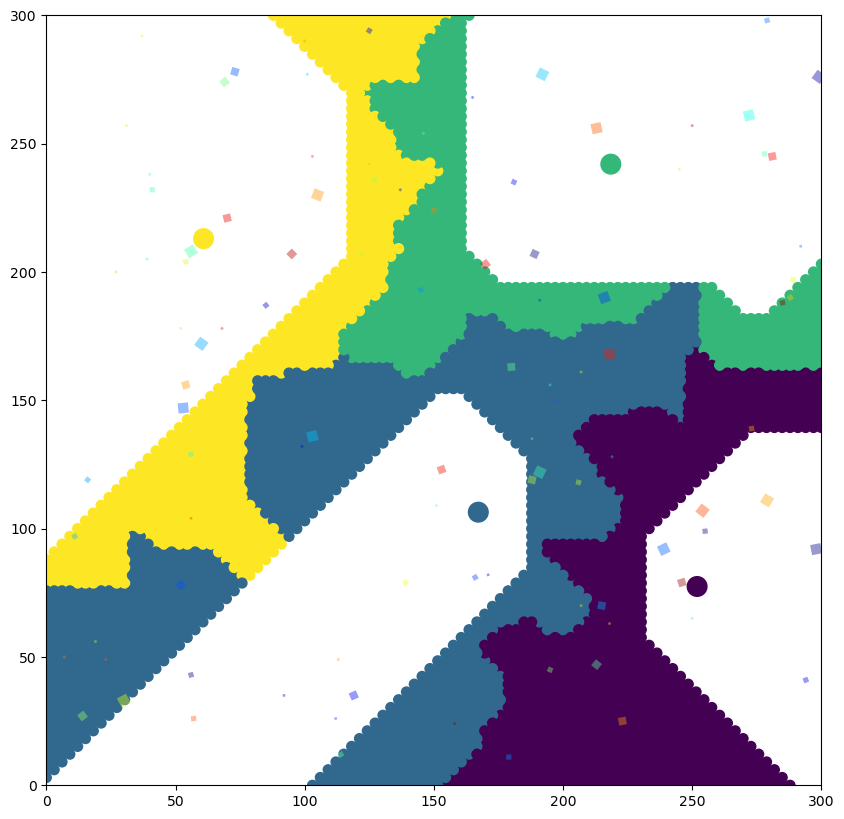

In [11]:
# plot qp
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# labels are z
labels =  z
plt_qp = qp.cpu().detach().numpy()
new_labels = F_ps.min(1)[1].cpu().detach().numpy()
ax.scatter(plt_qp[:, 0], plt_qp[:, 1], c=new_labels, s=50)
# plot best_outputs
plt_bo = best_outputs.cpu().detach().numpy()
plt_bo = plt_bo
c = np.linspace(0, best_outputs.shape[0], best_outputs.shape[0])
ax.scatter(plt_bo[:, 0], plt_bo[:, 1], c=c, s=200)
z_labels = z
pt.plot_data_on_manifold(fig, ax, squares, size=10, limits=[0, 300, 0, 300])
# plot_data(fig,ax,sq, size=10, limits=[0,300,0,300])

## Training Student

In [12]:
from src.models import Voronoi
from src.train import trainStudent

vor = Voronoi(4, 2, 2).to(device) # initialize the voronoi network
epochs = 30000 # number of epochs
best_vor_model, cost_ll, acc_l, es = trainStudent(vor,
                                                  optimizer=torch.optim.Adam(vor.parameters(), lr=1e-3),
                                                  epochs=epochs,
                                                  device=device,
                                                  loss_function=nn.L1Loss(),
                                                  qp=torch.tensor(qp), # send qp to device
                                                  F_ps=F_ps)

# Save voronoi model.
torch.save(best_vor_model.state_dict(), "models/squares/100/student_config.pt")
print("Saved student config to models/squares/100/student_config.pt")

/tmp/ipykernel_7359/2270234862.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp=torch.tensor(qp), # send qp to device
/home/getekid/Sites/athenarc/GeoCluster/src/train.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp).to(device)
/home/getekid/Sites/athenarc/GeoCluster/src/train.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp, dtype=torch.float32).to(device)


Training Teacher Model
Acc:  0.2540847738574473
Epoch:  0 Cost:  751.7493286132812
Acc:  0.8697608335306654
Epoch:  2000 Cost:  33.6826171875
Acc:  0.9277764622306417
Epoch:  4000 Cost:  24.410602569580078
Acc:  0.9422211697845134
Epoch:  6000 Cost:  19.266199111938477
Acc:  0.9329860288894151
Epoch:  8000 Cost:  17.468551635742188
Acc:  0.9419843713000237
Epoch:  10000 Cost:  15.477442741394043
Acc:  0.9197253137579919
Epoch:  12000 Cost:  17.77464485168457
Acc:  0.9336964243428842
Epoch:  14000 Cost:  15.650407791137695
Acc:  0.9237508879943168
Epoch:  16000 Cost:  16.10354995727539
Acc:  0.9294340516220696
Epoch:  18000 Cost:  15.207406997680664
Acc:  0.9599810561212408
Epoch:  20000 Cost:  12.297983169555664
Acc:  0.9500355197726734
Epoch:  22000 Cost:  12.393295288085938
Acc:  0.9360644091877812
Epoch:  24000 Cost:  13.533331871032715
Acc:  0.9512195121951219
Epoch:  26000 Cost:  12.078790664672852
Acc:  0.9386691925171678
Epoch:  28000 Cost:  13.091568946838379
Saved student conf

Plot Accuracy and Loss

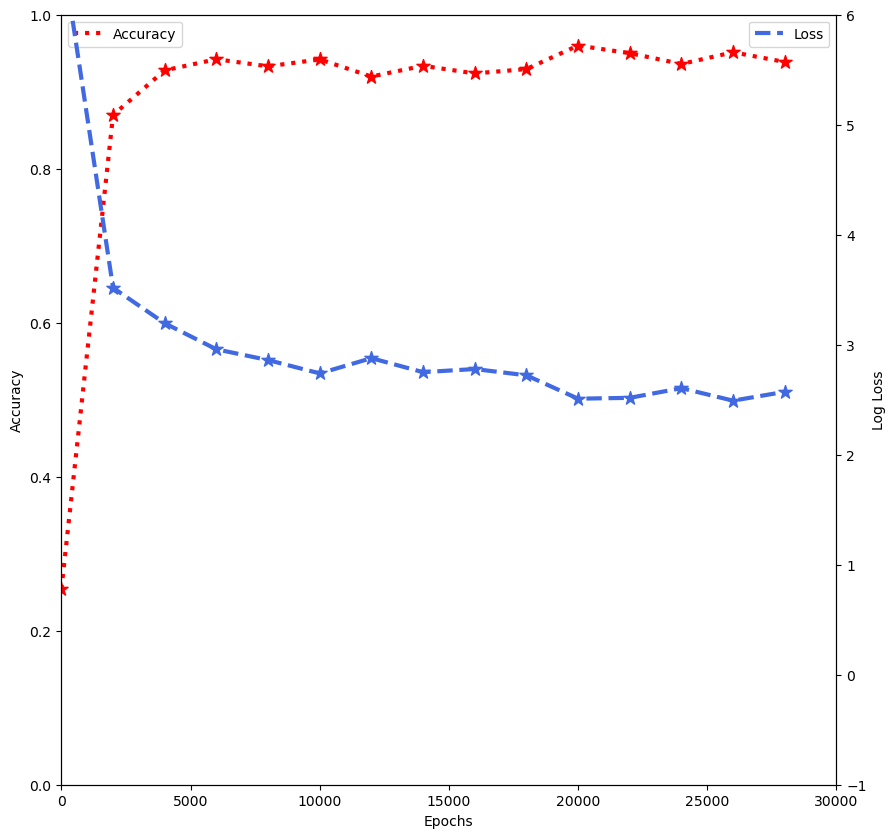

In [13]:
cost_ll_log = np.log(cost_ll)
    
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.plot(es, acc_l, c='r', label='Accuracy', linestyle='dotted', linewidth=3)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')
ax1.set_ylim([0, 1])
# create another twin axis
ax2 = ax1.twinx()
ax2.plot(es, cost_ll_log, c='royalblue', label='Loss', linestyle='dashed', linewidth=3)
ax2.set_ylabel('Log Loss')
ax2.legend(loc='upper right')
ax2.set_ylim([-1, 6])
# set x_lim in both
ax1.set_xlim([0, epochs])
ax2.set_xlim([0, epochs])
# add stars to the plot points
ax1.scatter(es, acc_l, c='r', s=100, marker='*')
ax2.scatter(es, cost_ll_log, c='royalblue', s=100, marker='*')

## Inferencing

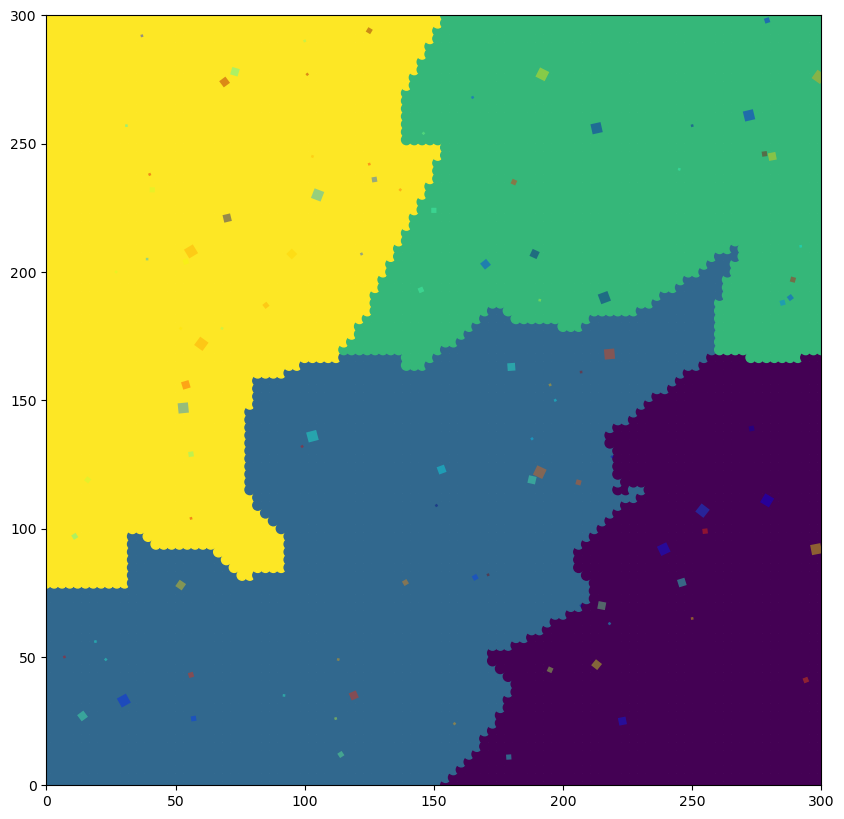

In [14]:
# ok lets infer
infer_points = torch.zeros(10000, 2) # initialize the infer points
x_lim = [0, 300] # x limits
y_lim = [0, 300] # y limits
for i, x in enumerate(np.linspace(x_lim[0], x_lim[1], 100)): # sample 100 points in x_lim
    for j, y in enumerate(np.linspace(y_lim[0], y_lim[1], 100)): # sample 100 points in y_lim
        infer_points[i * 100 + j] = torch.Tensor([x, y]) # append the point to infer_points

infer_points = infer_points.to(device) # send infer_points to device
classes = best_vor_model(infer_points) # get the classes of infer_points
infer_points = infer_points.cpu().detach().numpy() # send infer_points to cpu
classes = classes.max(1)[-1].cpu().detach().numpy() # send classes to cpu

# Plot classes.
fig = plt.figure(figsize=(10, 10)) # initialize the figure
ax = fig.add_subplot(111) # add subplot
ax.scatter(infer_points[:, 0], infer_points[:, 1], c=classes, s=50) # plot infer_points
# plot scatter of output = model(model.z)
pt.plot_data_on_manifold(fig, ax, squares, size=10, limits=[0, 300, 0, 300]) # plot sq

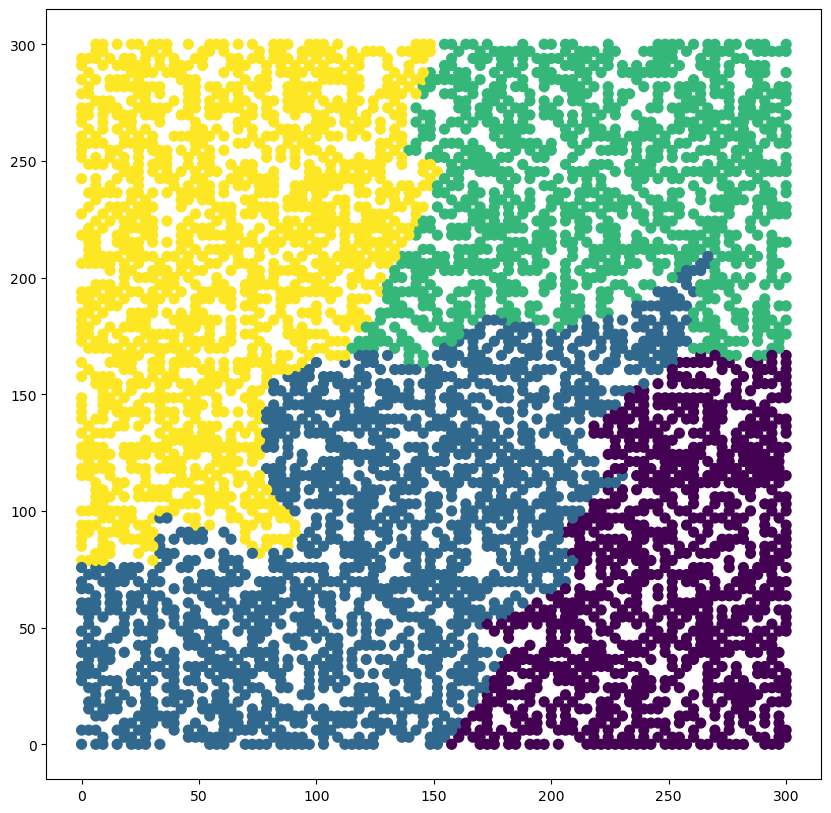

In [15]:
# Take 5000 randomly of those 10000 points randomly in [0,300]x[0,300].
infer_points = torch.from_numpy(infer_points)
infer_points = infer_points[torch.randperm(infer_points.shape[0])][:5000]
infer_points = infer_points.to(device)
classes = best_vor_model(infer_points)
z = classes.max(1)[-1].cpu().detach().numpy()
infer_points = infer_points.cpu().detach().numpy()
# plot infer_points
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(infer_points[:, 0], infer_points[:, 1], c=z, s=50)

### Randomly inferred points.

In [16]:
outputs_shape = (infer_points.shape[0], model.n_centroids) # initialize outputs shape
F_ps_infer = torch.zeros(outputs_shape) # initialize F_ps
z_ps_infer = torch.zeros(outputs_shape) # initialize z_ps
for i in range(outputs_shape[0]): # for each infer point
    if i % 1000 == 0: # print every 1000 points
        print(f"Labeled {i}/{outputs_shape[0]} points.")
    for j in range(outputs_shape[1]): # for each pseudo cluster
        qpoint = infer_points[i] # get the infer point
        F_ps_infer[i, j], z_ps_infer[i, j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j])) # get the Linf distance between the infer point and the pseudo cluster

print(f"Labeled all {outputs_shape[0]}/{outputs_shape[0]} points.")
z_i = F_ps_infer.min(1)[1].cpu().detach().numpy() # get the z_i

Labeled 0/5000 points.
Labeled 1000/5000 points.
Labeled 2000/5000 points.
Labeled 3000/5000 points.
Labeled 4000/5000 points.
Labeled all 5000/5000 points.


Get Accuracy

In [17]:
# get all the number of times z == z_i
times = [z == z_i]
print(np.sum(times) / z.shape[0])
print("Number of false predictions: ", z.shape[0] - np.sum(times))

0.97
Number of false predictions:  150


Plot points.

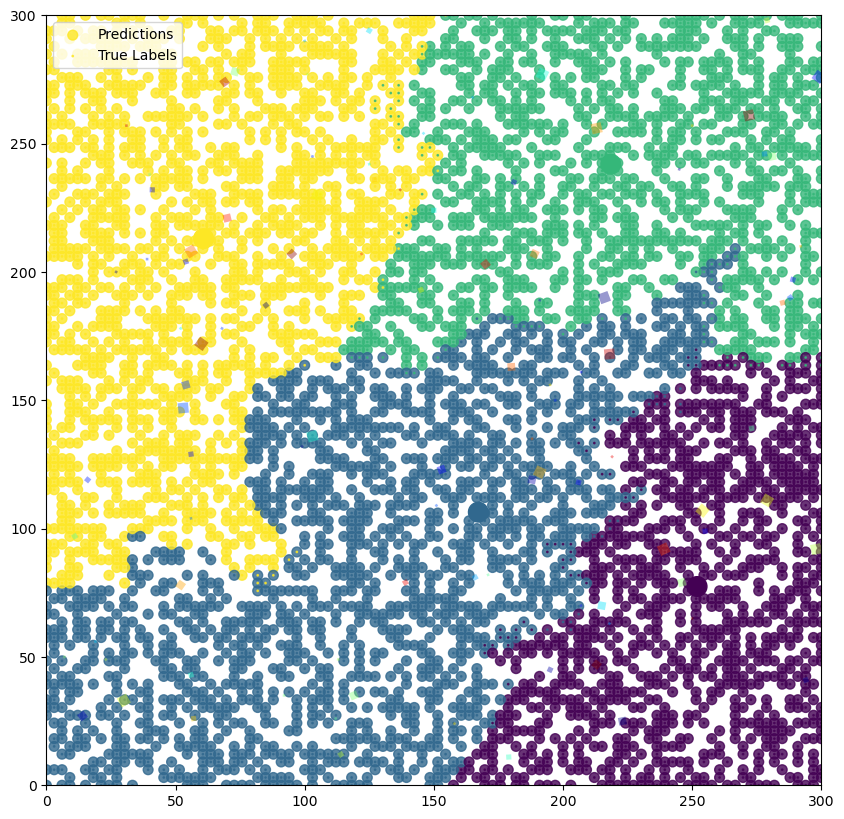

In [18]:
fig = plt.figure(figsize=(10, 10)) # initialize the figure
ax = fig.add_subplot(111) # add subplot
infer_points_plt = infer_points # infer_points
#z = z
classes_ = z # z
ax.scatter(infer_points_plt[:, 0], infer_points_plt[:, 1], c=z, s=50, label='Predictions', alpha=0.8) # plot infer_points
# plot z_i labels
# color
classes_ = z_i # z_i
ax.scatter(infer_points_plt[:, 0], infer_points_plt[:, 1], c=classes_, s=1, label='True Labels', alpha=0.8) # plot infer_points
ax.set_xlim([0, 300])
ax.set_ylim([0, 300])
# plot legend
plt.legend(scatterpoints=1, loc='upper left', fontsize=10)
# also vis data
pt.plot_data_on_manifold(fig, ax, squares, size=10, limits=[0, 300, 0, 300])
# plot best_outputs
plt_bo = best_outputs.cpu().detach().numpy()
plt_bo = plt_bo
c = np.linspace(0, best_outputs.shape[0], best_outputs.shape[0])
ax.scatter(plt_bo[:, 0], plt_bo[:, 1], c=c, s=200)